## Camera Calibration

## EDITED FROM KAGGLE by safal

### Variables

In [14]:
VIDEO_CALIBRATION_PATH = "assets/calibration.MP4"
EXTRACT_FRAMES = False
CHECKERBOARD_SIZE = (6, 8)

### Imports

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from termcolor import colored
import imageio

In [16]:
if EXTRACT_FRAMES:
    reader = imageio.get_reader(VIDEO_CALIBRATION_PATH)

    try:
        for i, frame in enumerate(reader):
            cv2.imwrite(f'assets/calibration_frames/frame_{i}.png', cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
            print(f'Read frame: {i}', end='\r')
    except Exception as e:
        print(f'An error occurred: {e}')
    finally:
        reader.close()

### Calibration matrix

In [17]:
# Init our checkerboard in 3 dimensions
# checkerboard_world_space = np.zeros((CHECKERBOARD_SIZE[0]*CHECKERBOARD_SIZE[1],3), np.float32)
# checkerboard_world_space[:,:2] = np.mgrid[0:CHECKERBOARD_SIZE[0],0:CHECKERBOARD_SIZE[1]].T.reshape(-1,2)

# objpoints = [] # 3D points in real world space
# imgpoints = [] # 2D points in image plane

# for file in glob.glob('assets/calibration_frames/*.png'):
#     img = cv2.imread(file)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#     # Find the chess board corners, thank you cv2 for providing such a useful function
#     ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD_SIZE, None)

#     if ret == True:
#         objpoints.append(checkerboard_world_space)
#         imgpoints.append(corners)

# # Calibrate camera
# ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# print(colored("Camera matrix:\n\n", "green"), mtx, "\n")
# print(colored("Distortion coefficients:\n\n", "green"), dist)

In [18]:
def calibrate_camera_with_subsets(subset_size=100, n_experiments=20):
    files = glob.glob('assets/calibration_frames/*.png')
    np.random.seed(42)
        
    camera_matrices = []
    distortion_coefficients = []
    
    best_mtx = None
    best_dist = None
    lowest_error = np.inf
    
    for _ in range(n_experiments):
        random_selected_files = np.random.choice(files, size=subset_size, replace=False)
        
        objpoints = [] # 3D points in real world space
        imgpoints = [] # 2D points in image plane
        
        checkerboard_world_space = np.zeros((CHECKERBOARD_SIZE[0]*CHECKERBOARD_SIZE[1], 3), np.float32)
        checkerboard_world_space[:, :2] = np.mgrid[0:CHECKERBOARD_SIZE[0], 0:CHECKERBOARD_SIZE[1]].T.reshape(-1, 2)
        
        for file in random_selected_files:
            img = cv2.imread(file)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Find the chess board corners
            ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD_SIZE, None)
            
            # If found, add object points, image points
            if ret == True:
                objpoints.append(checkerboard_world_space)
                imgpoints.append(corners)
        
        # Calibrate camera
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        
        # Store calibration parameters
        if ret:
            camera_matrices.append(mtx)
            distortion_coefficients.append(dist)
            
            # Calculate re-projection error
            mean_error = 0
            for i in range(len(objpoints)):
                imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
                error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
                mean_error += error
            
            if(mean_error < lowest_error):
                lowest_error = mean_error
                best_mtx = mtx
                best_dist = dist
    
    # Numpy is more efficient...
    camera_matrices = np.array(camera_matrices)
    distortion_coefficients = np.array(distortion_coefficients)
    
    # Compute standard deviation
    camera_matrices_std = np.std(camera_matrices, axis=0)
    distortion_coefficients_std = np.std(distortion_coefficients, axis=0)
    
    return best_mtx, best_dist, camera_matrices_std, distortion_coefficients_std

In [21]:
best_mtx, best_dist, camera_matrices_std, distortion_coefficients_std = calibrate_camera_with_subsets()
print(colored("Standard deviation of camera matrices:\n", 'green'), camera_matrices_std)
print(colored("\nStandard deviation of distortion coefficients:\n", 'green'), distortion_coefficients_std)
print(colored("\nBest camera matrix:\n", 'green'), best_mtx)
print(colored("\nBest distortion coefficients:\n", 'green'), best_dist)

Standard deviation of camera matrices:

 [[3.70849068 0.         5.82549989]

 [0.         2.98369589 9.05924656]

 [0.         0.         0.        ]]



Standard deviation of distortion coefficients:

 [[0.00296308 0.00773438 0.00029421 0.00040361 0.00619906]]



Best camera matrix:

 [[1.41527706e+03 0.00000000e+00 1.32534026e+03]

 [0.00000000e+00 1.42789878e+03 8.00498436e+02]

 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]



Best distortion coefficients:

 [[-0.28111115  0.14996815  0.00110429  0.00084166 -0.05461088]]


## Results
```py
Standard deviation of camera matrices:
 [[3.70849068 0.         5.82549989]
 [0.         2.98369589 9.05924656]
 [0.         0.         0.        ]]

Standard deviation of distortion coefficients:
 [[0.00296308 0.00773438 0.00029421 0.00040361 0.00619906]]

Best camera matrix:
 [[1.41527706e+03 0.00000000e+00 1.32534026e+03]
 [0.00000000e+00 1.42789878e+03 8.00498436e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Best distortion coefficients:
 [[-0.28111115  0.14996815  0.00110429  0.00084166 -0.05461088]]
 ```

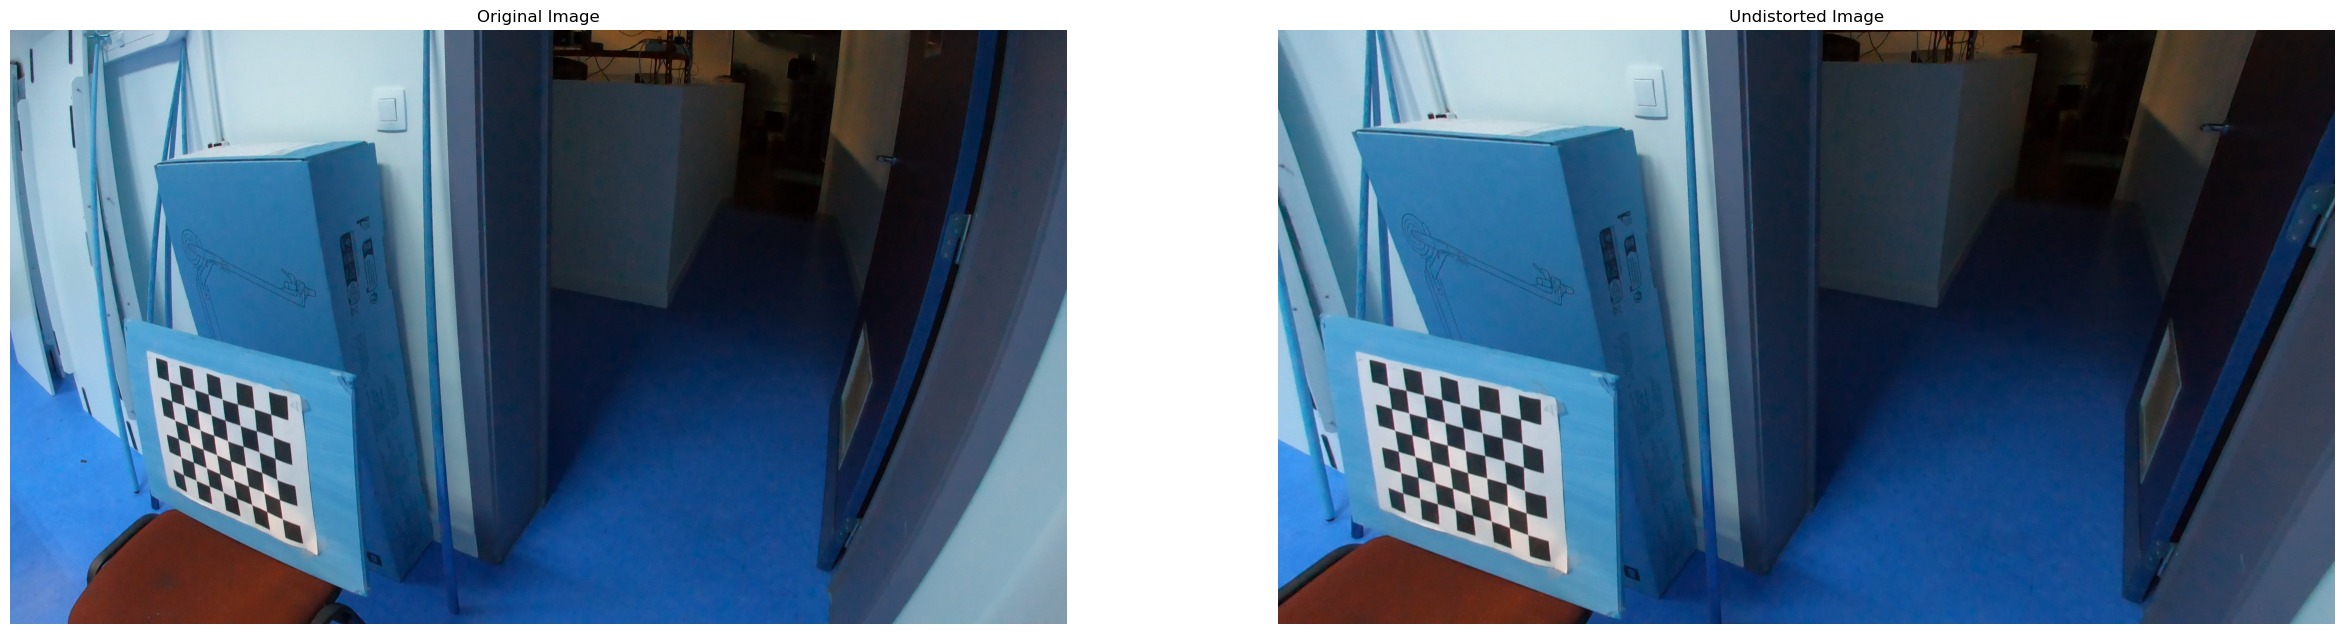

In [22]:
frame_test = cv2.imread('assets/calibration_frames/frame_555.png')

# Undistort image
undistorted_img = cv2.undistort(frame_test, best_mtx, best_dist, None, best_mtx)

fig, axs = plt.subplots(1, 2, figsize=(30, 20))
axs[0].imshow(frame_test)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(undistorted_img)
axs[1].set_title('Undistorted Image')
axs[1].axis('off')

plt.show()